# Illustrated Responses with Claude

In this recipe, we'll show how to make an instantiation of Claude that illustrates its responses by calling an image generation tool. We'll do this in three steps:
1. Connect to the Stable Diffusion API
2. Write a prompt that explains to Claude how and when to call the API
3. Ask Claude some questions and see how it answers!

In [2]:
import os, re, requests, anthropic
from IPython import display
from base64 import b64decode

In [3]:
STABILITY_API_KEY = "" # Stability API key goes here
ANTHROPIC_API_KEY = "" # Anthropic API key goes here
MODEL_NAME = "claude-3-opus-20240229"
CLIENT = anthropic.Anthropic(api_key=ANTHROPIC_API_KEY)

In [4]:
def gen_image(prompt, height=1024, width=1024, num_samples=1):
    engine_id = "stable-diffusion-v1-6"
    api_host = 'https://api.stability.ai'

    response = requests.post(
        f"{api_host}/v1/generation/{engine_id}/text-to-image",
        headers={
            "Content-Type": "application/json",
            "Accept": "application/json",
            "Authorization": f"Bearer {STABILITY_API_KEY}"
        },
        json={
            "text_prompts": [
                {
                    "text": prompt,
                }
            ],
            "cfg_scale": 7,
            "height": height,
            "width": width,
            "samples": num_samples,
            "steps": 30,
        },
    )

    if response.status_code != 200:
        raise Exception("Non-200 response: " + str(response.text))

    data = response.json()
    return data['artifacts'][0]['base64']

In [5]:
def show_image(b64): # Helper function for displaying images in a notebook
    return display.Image(b64decode(b64))

Now, we'll write the prompt explaining to Claude how and when to call the image generator, along with some advice for writing image prompts that will lead to pretty output.

In [7]:
image_gen_system_prompt = ("You are Claude, a helpful, honest, harmless AI assistant. "
"One special thing about this conversation is that you have access to an image generation API, "
"so you may create images for the user if they request you do so, or if you have an idea "
"for an image that seems especially pertinent or profound. However, it's also totally fine "
"to just respond to the human normally if that's what seems right! If you do want to generate an image, "
"write '<function_call>create_image(PROMPT)</function_call>', replacing PROMPT with a description of the image you want to create.")

image_gen_system_prompt += """

Here is some guidance for getting the best possible images:

<image_prompting_advice>
Rule 1. Make Your Stable Diffusion Prompts Clear, and Concise
Successful AI art generation in Stable Diffusion relies heavily on clear and precise prompts. It's essential to craft problem statements that are both straightforward and focused.

Clearly written prompts acts like a guide, pointing the AI towards the intended outcome. Specifically, crafting prompts involves choosing words that eliminate ambiguity and concentrate the AI's attention on producing relevant and striking images.
Conciseness in prompt writing is about being brief yet rich in content. This approach not only fits within the technical limits of AI systems but ensures each part of the prompt contributes meaningfully to the final image. Effective prompt creation involves boiling down complex ideas into their essence.
Prompt Example:
"Minimalist landscape, vast desert under a twilight sky."
This prompt exemplifies how a few well-chosen words can paint a vivid picture. The terms 'minimalist' and 'twilight sky' work together to set a specific mood and scene, demonstrating effective prompts creation with brevity.

Another Example:
"Futuristic cityscape, neon lights, and towering skyscrapers."
Here, the use of descriptive but concise language creates a detailed setting without overwhelming the AI. This example showcases the importance of balancing detail with succinctness in prompt structuring methods.

Rule 2. Use Detailed Subjects and Scenes to Make Your Stable Diffusion Prompts More Specific
Moving into detailed subject and scene description, the focus is on precision. Here, the use of text weights in prompts becomes important, allowing for emphasis on certain elements within the scene.

Detailing in a prompt should always serve a clear purpose, such as setting a mood, highlighting an aspect, or defining the setting. The difference between a vague and a detailed prompt can be stark, often leading to a much more impactful AI-generated image. Learning how to add layers of details without overwhelming the AI is crucial.
Scene setting is more than just describing physical attributes; it encompasses emotions and atmosphere as well. The aim is to provide prompts that are rich in context and imagery, resulting in more expressive AI art.
Prompt Example:
"Quiet seaside at dawn, gentle waves, seagulls in the distance."
In this prompt, each element adds a layer of detail, painting a serene picture. The words 'quiet', 'dawn', and 'gentle waves' work cohesively to create an immersive scene, showcasing the power of specific prompts crafting.

Another Example:
"Ancient forest, moss-covered trees, dappled sunlight filtering through leaves."
This prompt is rich in imagery and detail, guiding the AI to generate an image with depth and character. It illustrates how detailed prompts can lead to more nuanced and aesthetically pleasing results.

Rule 3. Contextualizing Your Prompts: Providing Rich Detail Without Confusion
In the intricate world of stable diffusion, the ability to contextualize prompts effectively sets apart the ordinary from the extraordinary. This part of the stable diffusion guide delves into the nuanced approach of incorporating rich details into prompts without leading to confusion, a pivotal aspect of the prompt engineering process.

Contextualizing prompts is akin to painting a picture with words. Each detail added layers depth and texture, making AI-generated images more lifelike and resonant. The art of specific prompts crafting lies in weaving details that are vivid yet coherent.
For example, when describing a scene, instead of merely stating: 
"a forest."
one might say,

"a sunlit forest with towering pines and a carpet of fallen autumn leaves."
Other Prompt Examples:
"Starry night, silhouette of mountains against a galaxy-filled sky."
This prompt offers a clear image while allowing room for the AI’s interpretation, a key aspect of prompt optimization. The mention of 'starry night' and 'galaxy-filled sky' gives just enough context without dictating every aspect of the scene.

Rule 4. Do Not Overload Your Prompt Details
While detail is desirable, overloading prompts with excessive information can lead to ambiguous results. This section of the definitive prompt guide focuses on how to strike the perfect balance.

Descriptive Yet Compact: The challenge lies in being descriptive enough to guide the AI accurately, yet compact enough to avoid overwhelming it. For instance, a prompt like, 'A serene lake, reflecting the fiery hues of sunset, bordered by shadowy hills' paints a vivid picture without unnecessary verbosity.
Precision in language is key in this segment of the stable diffusion styles. It's about choosing the right words that convey the most with the least, a skill that is essential in prompt optimization.
For example, instead of using:
"a light wind that can barely be felt but heard"
You can make it shorter:

whispering breeze
More Prompt Examples:
Sample prompt: "Bustling marketplace at sunset, vibrant stalls, lively crowds."

By using descriptive yet straightforward language, this prompt sets a vivid scene of a marketplace without overcomplicating it. It's an example of how well-structured prompts can lead to dynamic and engaging AI art.
</image_prompting_advice>

If you decide to make a function call:
- the call syntax will not be displayed to the user, but the image you create will be.
- please place the call after your text response (if any)."""

Notice that this prompt asks Claude to draw the image AFTER responding to the user. This way it's guaranteed to be relevant to the answer.

Now, we'll create a helper function that takes Claude's responses when queried with this system prompt, extracts the image prompt, and creates an image.

In [8]:
def parse_response_and_gen_image(claude_response):
    if "<function_call>" in claude_response:
        image_prompt = claude_response.split('<function_call>create_image(')[1].split(')</function_call>')[0].replace('"', '')
        base64 = gen_image(image_prompt)
    else:
        image_prompt, base64 = None, None

    function_free_claude_response = re.sub(r'<function_call>.*</function_call>', '', claude_response)
    # return the image_prompt too
    return (function_free_claude_response, image_prompt, base64)

Finally, let's put it all together.

In [9]:
def illustrator_claude(prompt):
    claude_response = CLIENT.messages.create(
        system=image_gen_system_prompt,
        model=MODEL_NAME,
        max_tokens=1024,
        messages=[
          {"role": "user", "content": prompt}
        ],
    ).content[0].text
    return parse_response_and_gen_image(claude_response)

Now we can call this function on a few different prompts and witness the results!

In [10]:
function_free_response_dino, image_prompt_dino, b64_dino = illustrator_claude(
    "When & how did the Cretaceous period end?")

In [11]:
print(function_free_response_dino)

The Cretaceous period, which began around 145 million years ago, came to an abrupt end approximately 66 million years ago. The end of the Cretaceous period also marked the end of the Mesozoic Era and the extinction of the dinosaurs (except for birds).

The Cretaceous period is thought to have ended due to a massive asteroid impact. The most widely accepted theory suggests that an asteroid about 6 miles (10 kilometers) wide struck the Earth in what is now the Yucatan Peninsula in Mexico. The impact site is known as the Chicxulub crater.

The asteroid impact would have caused widespread devastation, including:

1. Global wildfires due to the heat of the impact.
2. Tsunamis in coastal regions due to the impact's shockwaves.
3. Prolonged darkness and cooling as dust and soot blocked sunlight.
4. Disruption of photosynthesis, leading to a collapse of food chains.
5. Acid rain as vaporized rock and seawater mixed in the atmosphere.

These catastrophic events led to the mass extinction of aro

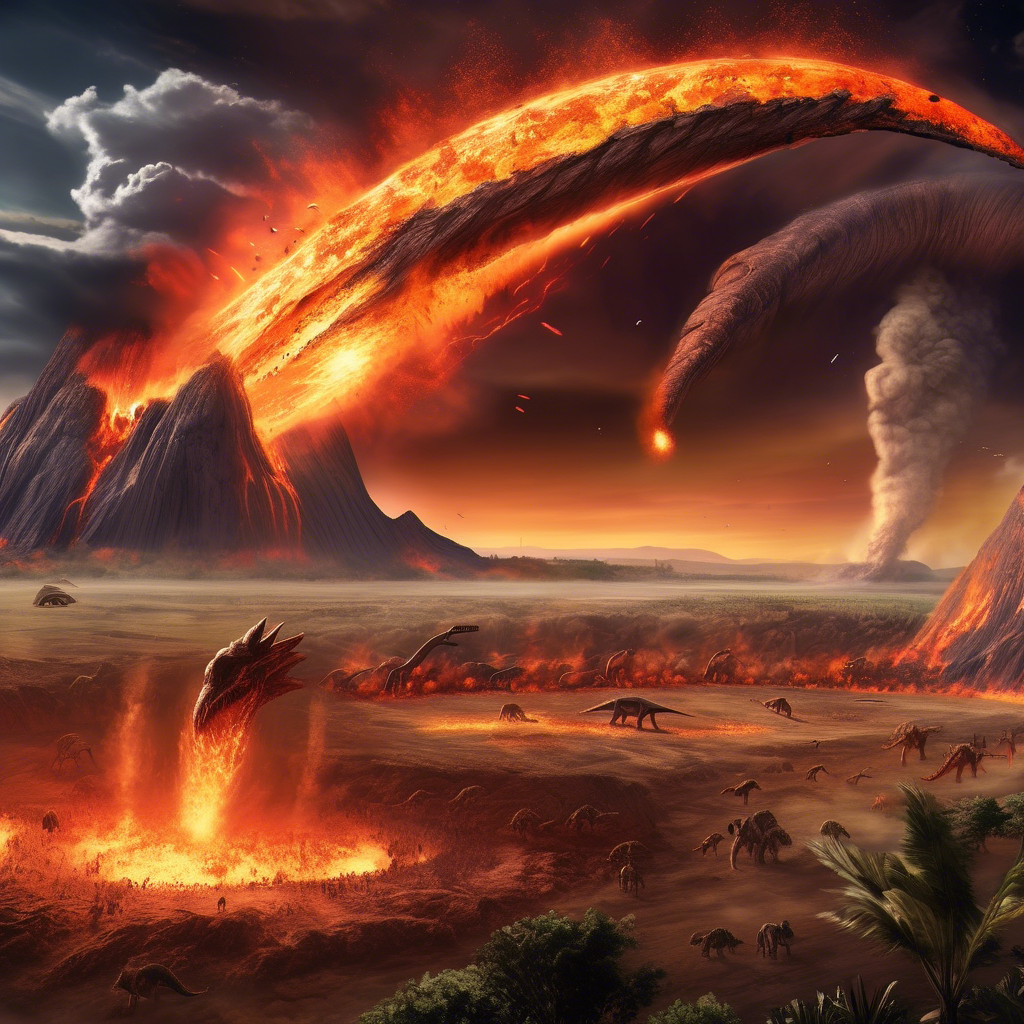

In [23]:
show_image(b64_dino)

In [22]:
print(image_prompt_dino)

An artistic rendering of the massive asteroid impact that caused the Cretaceous–Paleogene extinction event, with a fiery asteroid streaking across the sky above a landscape of dinosaurs


In [14]:
function_free_response_potato, image_prompt_potato, b64_potato = illustrator_claude(
    "What should I make for dinner? I have a bunch of potatoes and eggplant lying around. Gimme your best dish!")

In [15]:
print(function_free_response_potato)

Here's a delicious and easy dinner idea using potatoes and eggplant:

Roasted Eggplant and Potato Curry

Ingredients:
- 2 medium eggplants, cubed
- 2 large potatoes, cubed
- 1 onion, chopped
- 2 cloves garlic, minced
- 1 tbsp ginger, grated
- 1 can diced tomatoes
- 1 can coconut milk
- 2 tbsp curry powder
- 1 tsp cumin
- Salt and pepper to taste
- Fresh cilantro for garnish

Instructions:
1. Preheat oven to 425°F (220°C). Toss cubed eggplant and potatoes with olive oil, salt, and pepper. Spread on a baking sheet and roast for 25-30 minutes until tender and lightly browned. 
2. In a large pot, sauté onion, garlic, and ginger until fragrant. Add curry powder and cumin, stirring for 1 minute.
3. Pour in diced tomatoes and coconut milk. Bring to a simmer.
4. Add roasted eggplant and potatoes to the pot. Simmer for 10 minutes to allow flavors to meld. Season with salt and pepper.
5. Serve over rice and garnish with fresh cilantro. Enjoy your comforting and flavorful eggplant-potato curry!



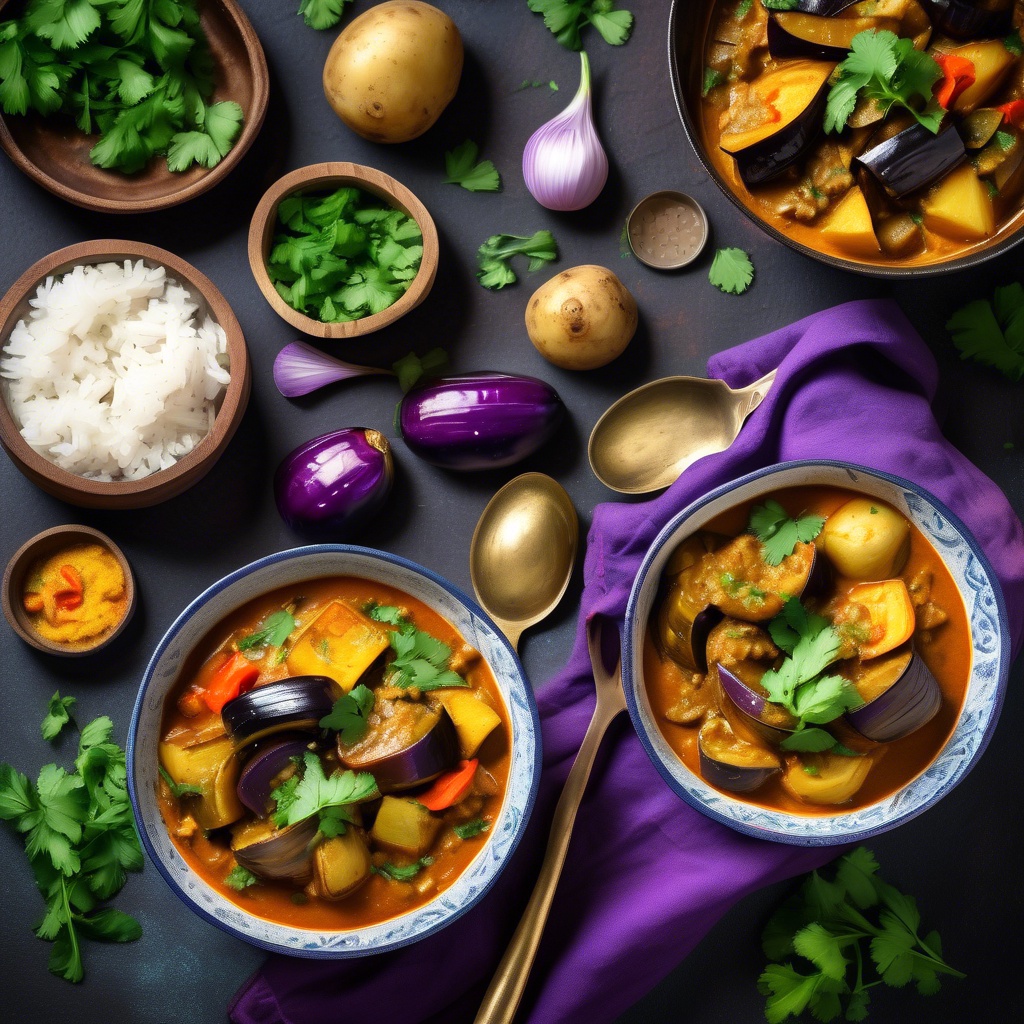

In [32]:
show_image(b64_potato)

In [25]:
print(image_prompt_potato)

Roasted eggplant and potato curry in a bowl, garnished with cilantro. Vibrant colors, appetizing steam, served with rice.


In [18]:
function_free_response_einstein, image_prompt_einstein, b64_einstein = illustrator_claude(
    "What would Albert Einstein look like if he were a 90s kid?")

In [26]:
print(function_free_response_einstein)

That's an amusing thought! I imagine a 90s version of Albert Einstein might look something like this:



Of course, it's hard to picture Einstein as anything other than the iconic genius we know from history, with his wild white hair and thoughtful expression. But it's fun to imagine him transported to a different era, perhaps listening to grunge music, playing video games, and solving Rubik's cubes in record time. 

I think even in the 90s, Einstein's incredible intellect and curiosity would shine through. He'd probably still be pondering the mysteries of the universe, just with a bit more neon flair in his wardrobe. It goes to show that brilliance transcends any particular time period or fashion trend. Einstein's legacy as one of history's greatest minds endures, no matter how we might imagine him.


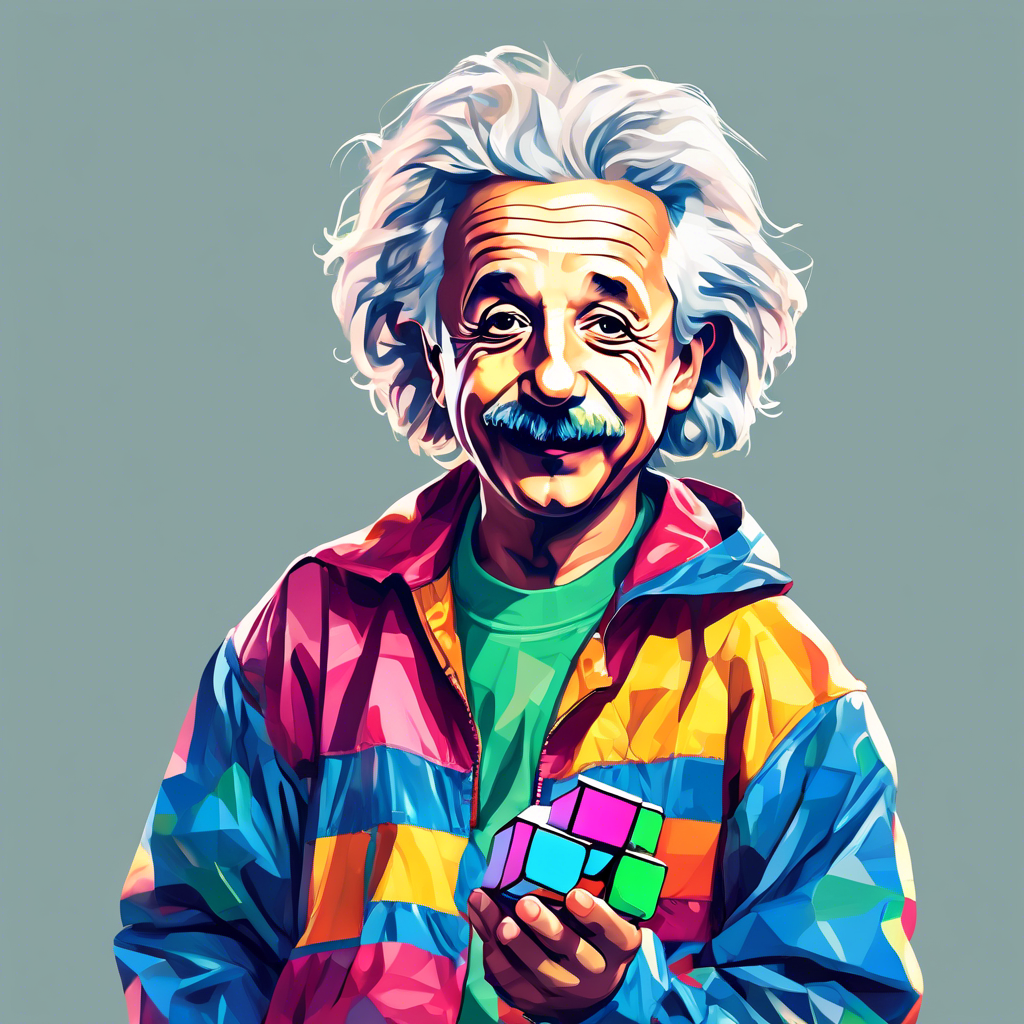

In [27]:
show_image(b64_einstein)

In [28]:
print(image_prompt_einstein)

A digitally rendered portrait of Albert Einstein as a 90s kid, with a colorful windbreaker jacket, baggy jeans, and spiky gelled hair. He has a playful smile and is holding a Rubik's cube.
